# Day 1: k-Nearest Neighbors (kNN) for Quantitative Trading

## 🎯 Learning Objectives
- Understand kNN algorithm and its application in finance
- Implement kNN for regime classification and trading signals
- Learn about distance metrics in financial context
- Build a trading strategy using kNN predictions

---

## 📚 Theory: k-Nearest Neighbors

### What is kNN?
k-Nearest Neighbors is a **non-parametric, instance-based** learning algorithm. It makes predictions based on the similarity of new data points to historical examples.

### The Algorithm
For a new observation $x$:
1. Calculate distance to all training points: $d(x, x_i)$
2. Select $k$ nearest neighbors
3. Classification: Vote (majority class)
4. Regression: Average of neighbor values

### Distance Metrics

**Euclidean Distance:**
$$d(x, y) = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

**Manhattan Distance:**
$$d(x, y) = \sum_{i=1}^{n}|x_i - y_i|$$

**Mahalanobis Distance (correlation-aware):**
$$d(x, y) = \sqrt{(x-y)^T S^{-1} (x-y)}$$

### Finance Applications
1. **Regime Classification**: Find similar historical market conditions
2. **Pairs Trading**: Identify similar securities
3. **Signal Generation**: Predict direction based on past patterns
4. **Risk Estimation**: Estimate future volatility from similar periods

### Pros and Cons

| Pros | Cons |
|------|------|
| Simple, intuitive | Computationally expensive (O(n) prediction) |
| No assumptions about data distribution | Sensitive to feature scaling |
| Naturally handles multi-class | Curse of dimensionality |
| Can capture non-linear patterns | No model to interpret |

### Real-World Use Cases
- **Two Sigma**: Pattern matching for regime detection
- **AQR**: Similarity-based factor construction
- **Renaissance Technologies**: Historical pattern matching

---

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download market data
tickers = ['SPY', 'AAPL', 'MSFT', 'GOOGL', 'JPM']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data loaded: {len(prices)} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1255 days


## 📊 Feature Engineering for kNN

Key principle: **Feature scaling is CRITICAL for kNN** since it uses distance metrics.

In [2]:
# Create features for kNN trading model
spy = prices['SPY'].copy()
spy_returns = returns['SPY'].copy()

# Feature engineering
features = pd.DataFrame(index=spy.index)

# Momentum features
features['return_1d'] = spy_returns
features['return_5d'] = spy_returns.rolling(5).sum()
features['return_20d'] = spy_returns.rolling(20).sum()

# Volatility features
features['vol_5d'] = spy_returns.rolling(5).std() * np.sqrt(TRADING_DAYS)
features['vol_20d'] = spy_returns.rolling(20).std() * np.sqrt(TRADING_DAYS)

# Technical indicators
features['rsi'] = 100 - (100 / (1 + spy_returns.rolling(14).apply(lambda x: (x[x>0].sum()) / (-x[x<0].sum() + 1e-10))))
features['ma_ratio'] = spy / spy.rolling(20).mean()
features['bb_position'] = (spy - spy.rolling(20).mean()) / (spy.rolling(20).std() * 2)

# Volume proxy (using price range as proxy)
features['range_20d'] = (spy.rolling(20).max() - spy.rolling(20).min()) / spy

# Target: Next day direction (1 = up, 0 = down)
features['target'] = (spy_returns.shift(-1) > 0).astype(int)

# Drop NaN
features = features.dropna()

print(f"\n📊 Features created: {features.shape[1]-1} features, {len(features)} samples")
print(f"\nFeature list:")
for col in features.columns[:-1]:
    print(f"  • {col}")


📊 Features created: 9 features, 1235 samples

Feature list:
  • return_1d
  • return_5d
  • return_20d
  • vol_5d
  • vol_20d
  • rsi
  • ma_ratio
  • bb_position
  • range_20d


In [3]:
# Prepare data for modeling
feature_cols = features.columns[:-1].tolist()
X = features[feature_cols]
y = features['target']

# Scale features (CRITICAL for kNN)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

# Time series train/test split (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X_scaled.iloc[:train_size], X_scaled.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\n📊 Data Split:")
print(f"  Training: {len(X_train)} samples ({X_train.index[0].date()} to {X_train.index[-1].date()})")
print(f"  Testing:  {len(X_test)} samples ({X_test.index[0].date()} to {X_test.index[-1].date()})")
print(f"\n  Train class balance: {y_train.mean():.1%} up days")
print(f"  Test class balance: {y_test.mean():.1%} up days")


📊 Data Split:
  Training: 988 samples (2021-02-23 to 2025-01-28)
  Testing:  247 samples (2025-01-29 to 2026-01-22)

  Train class balance: 53.9% up days
  Test class balance: 56.7% up days


## 🔧 Choosing Optimal k

The choice of $k$ is critical:
- **Small k**: Low bias, high variance (overfitting)
- **Large k**: High bias, low variance (underfitting)
- **Rule of thumb**: $k \approx \sqrt{n}$


🎯 Optimal k = 29 (CV accuracy: 52.68%)


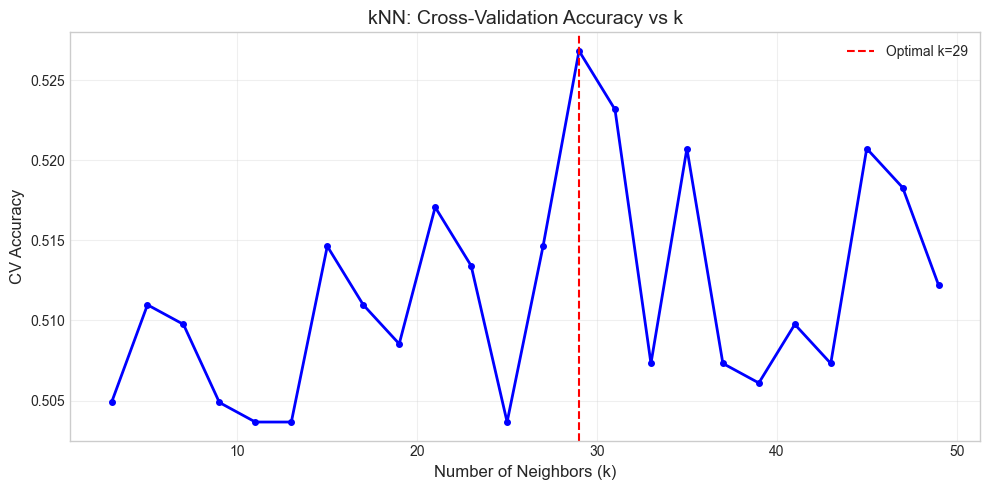

In [4]:
# Find optimal k using time series cross-validation
k_range = range(3, 51, 2)  # Odd numbers to avoid ties
cv_scores = []

tscv = TimeSeriesSplit(n_splits=5)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    fold_scores = []
    
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        knn.fit(X_tr, y_tr)
        fold_scores.append(knn.score(X_val, y_val))
    
    cv_scores.append(np.mean(fold_scores))

best_k = k_range[np.argmax(cv_scores)]
best_score = max(cv_scores)

print(f"\n🎯 Optimal k = {best_k} (CV accuracy: {best_score:.2%})")

# Plot k vs accuracy
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(k_range, cv_scores, 'b-o', linewidth=2, markersize=4)
ax.axvline(x=best_k, color='r', linestyle='--', label=f'Optimal k={best_k}')
ax.set_xlabel('Number of Neighbors (k)', fontsize=12)
ax.set_ylabel('CV Accuracy', fontsize=12)
ax.set_title('kNN: Cross-Validation Accuracy vs k', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Train final model with optimal k
knn_model = KNeighborsClassifier(
    n_neighbors=best_k,
    weights='distance',  # Weight by inverse distance
    metric='euclidean'
)

knn_model.fit(X_train, y_train)

# Predictions
y_pred = knn_model.predict(X_test)
y_proba = knn_model.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*60)
print("kNN MODEL RESULTS")
print("="*60)
print(f"\nTest Accuracy: {accuracy:.2%}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))


kNN MODEL RESULTS

Test Accuracy: 55.87%

Classification Report:
              precision    recall  f1-score   support

        Down       0.49      0.35      0.40       107
          Up       0.59      0.72      0.65       140

    accuracy                           0.56       247
   macro avg       0.54      0.53      0.53       247
weighted avg       0.55      0.56      0.54       247



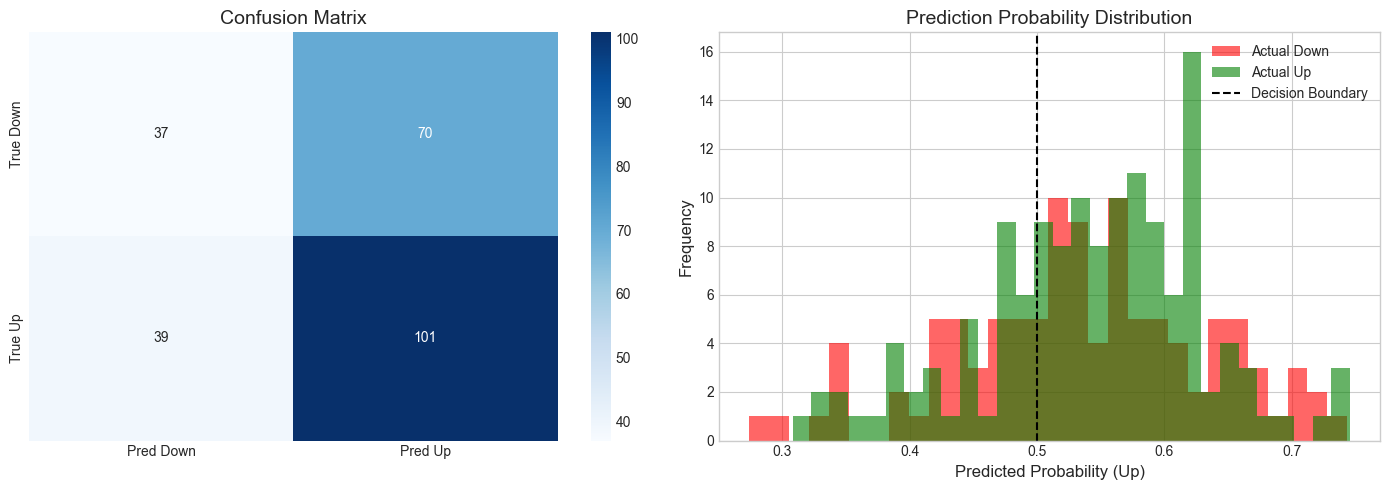

In [6]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Down', 'Pred Up'],
            yticklabels=['True Down', 'True Up'])
axes[0].set_title('Confusion Matrix', fontsize=14)

# Probability distribution
axes[1].hist(y_proba[y_test==0], bins=30, alpha=0.6, label='Actual Down', color='red')
axes[1].hist(y_proba[y_test==1], bins=30, alpha=0.6, label='Actual Up', color='green')
axes[1].axvline(x=0.5, color='black', linestyle='--', label='Decision Boundary')
axes[1].set_xlabel('Predicted Probability (Up)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Prediction Probability Distribution', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

## 📈 kNN Trading Strategy

Convert predictions into a trading strategy:
- **Signal > 0.5**: Go long
- **Signal ≤ 0.5**: Go to cash (or short)

In [7]:
# Build trading strategy
strategy = pd.DataFrame(index=X_test.index)
strategy['signal'] = y_proba
strategy['position'] = (strategy['signal'] > 0.5).astype(int)  # Long when prob > 0.5
strategy['spy_return'] = spy_returns.loc[X_test.index]
strategy['strategy_return'] = strategy['position'].shift(1) * strategy['spy_return']

# Calculate cumulative returns
strategy['spy_cumulative'] = (1 + strategy['spy_return']).cumprod()
strategy['strategy_cumulative'] = (1 + strategy['strategy_return']).cumprod()

# Performance metrics
def calculate_metrics(returns, name):
    total_return = (1 + returns).prod() - 1
    ann_return = (1 + total_return) ** (TRADING_DAYS / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_return - RISK_FREE_RATE) / ann_vol if ann_vol > 0 else 0
    max_dd = (returns.cumsum() - returns.cumsum().cummax()).min()
    
    return {
        'Strategy': name,
        'Total Return': f"{total_return:.2%}",
        'Ann. Return': f"{ann_return:.2%}",
        'Ann. Vol': f"{ann_vol:.2%}",
        'Sharpe': f"{sharpe:.2f}",
        'Max Drawdown': f"{max_dd:.2%}"
    }

results = []
results.append(calculate_metrics(strategy['spy_return'].dropna(), 'Buy & Hold SPY'))
results.append(calculate_metrics(strategy['strategy_return'].dropna(), 'kNN Strategy'))

results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("STRATEGY PERFORMANCE COMPARISON")
print("="*70)
print(results_df.to_string(index=False))


STRATEGY PERFORMANCE COMPARISON
      Strategy Total Return Ann. Return Ann. Vol Sharpe Max Drawdown
Buy & Hold SPY       15.59%      15.93%   19.44%   0.56      -20.23%
  kNN Strategy       28.73%      29.53%   15.57%   1.58      -11.11%


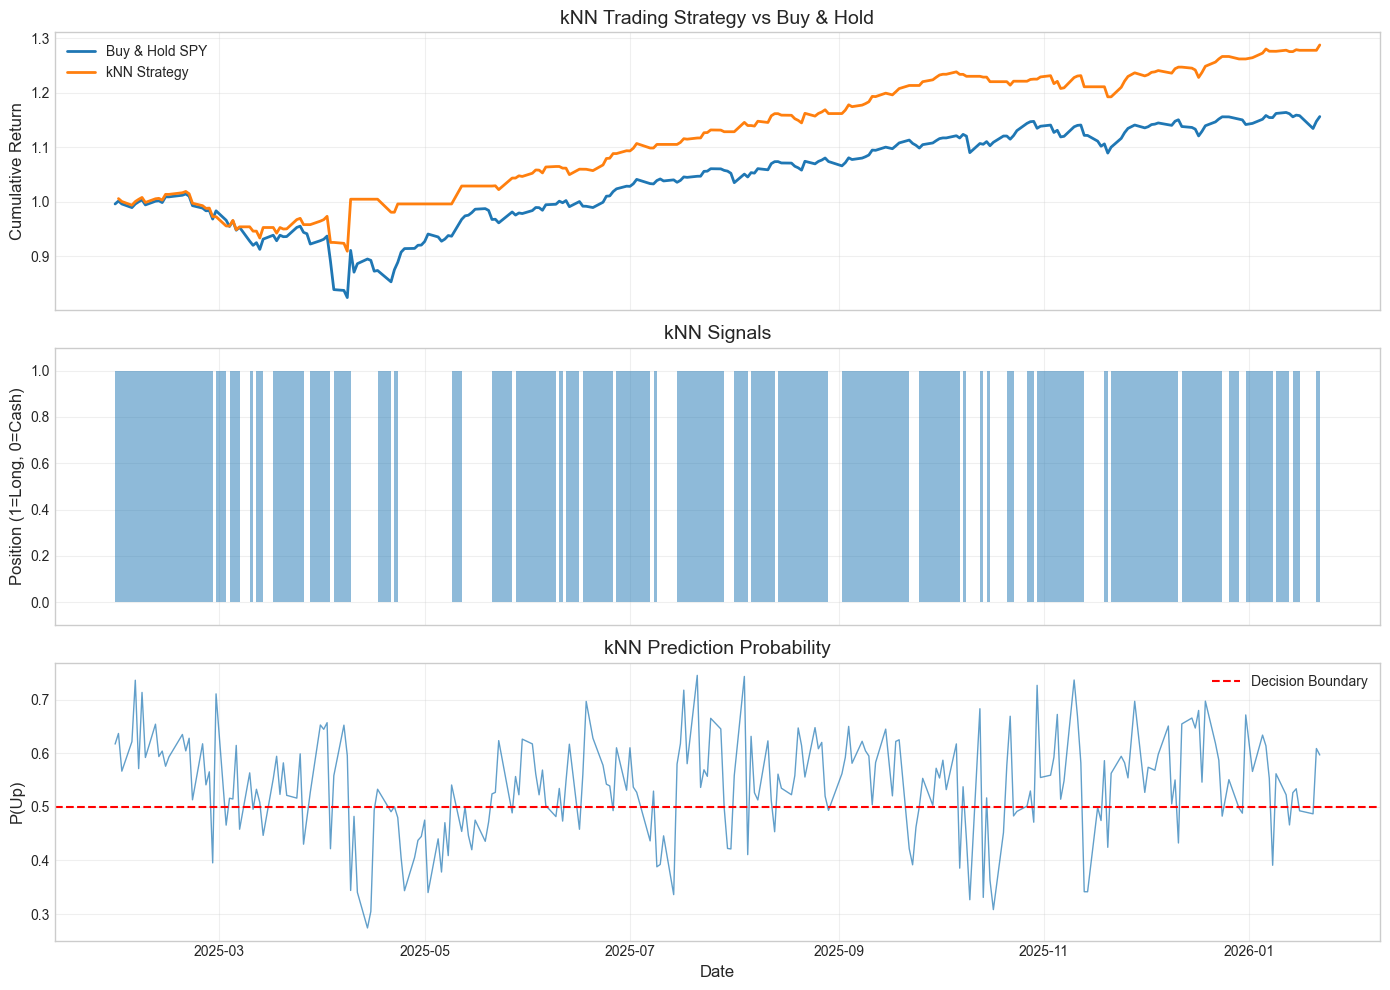

In [8]:
# Visualize strategy performance
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Cumulative returns
axes[0].plot(strategy.index, strategy['spy_cumulative'], label='Buy & Hold SPY', linewidth=2)
axes[0].plot(strategy.index, strategy['strategy_cumulative'], label='kNN Strategy', linewidth=2)
axes[0].set_ylabel('Cumulative Return', fontsize=12)
axes[0].set_title('kNN Trading Strategy vs Buy & Hold', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Position
axes[1].fill_between(strategy.index, strategy['position'], alpha=0.5, step='post', label='Position')
axes[1].set_ylabel('Position (1=Long, 0=Cash)', fontsize=12)
axes[1].set_title('kNN Signals', fontsize=14)
axes[1].set_ylim(-0.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Prediction probability
axes[2].plot(strategy.index, strategy['signal'], linewidth=1, alpha=0.7)
axes[2].axhline(y=0.5, color='r', linestyle='--', label='Decision Boundary')
axes[2].set_ylabel('P(Up)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_title('kNN Prediction Probability', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🔮 Next Day Prediction

Use the trained model to predict tomorrow's market direction.

In [9]:
# Get latest features for next day prediction
latest_features = X_scaled.iloc[-1:]

# Predict
next_day_proba = knn_model.predict_proba(latest_features)[0, 1]
next_day_pred = 'UP ↑' if next_day_proba > 0.5 else 'DOWN ↓'

# Find k nearest neighbors
distances, indices = knn_model.kneighbors(latest_features)
neighbor_dates = X_train.index[indices[0]]
neighbor_returns = spy_returns.loc[neighbor_dates].shift(-1).dropna()

print("\n" + "="*70)
print("📊 NEXT DAY PREDICTION")
print("="*70)
print(f"\nPrediction Date: {datetime.now().strftime('%Y-%m-%d')}")
print(f"Model: k-Nearest Neighbors (k={best_k})")
print(f"\n🎯 Prediction: {next_day_pred}")
print(f"   Confidence: {max(next_day_proba, 1-next_day_proba):.1%}")
print(f"   P(Up): {next_day_proba:.1%}")
print(f"\n📅 Similar Historical Days ({best_k} neighbors):")
for i, (date, dist) in enumerate(zip(neighbor_dates[:5], distances[0][:5])):
    next_ret = spy_returns.shift(-1).loc[date] if date in spy_returns.shift(-1).index else np.nan
    if not np.isnan(next_ret):
        print(f"   {i+1}. {date.strftime('%Y-%m-%d')} (distance: {dist:.3f}) → Next day: {next_ret:+.2%}")


📊 NEXT DAY PREDICTION

Prediction Date: 2026-01-22
Model: k-Nearest Neighbors (k=29)

🎯 Prediction: UP ↑
   Confidence: 59.7%
   P(Up): 59.7%

📅 Similar Historical Days (29 neighbors):
   1. 2021-07-21 (distance: 0.704) → Next day: +0.21%
   2. 2024-04-05 (distance: 0.859) → Next day: +0.06%
   3. 2021-06-22 (distance: 0.866) → Next day: -0.12%
   4. 2021-06-21 (distance: 0.890) → Next day: +0.53%
   5. 2021-07-22 (distance: 0.919) → Next day: +1.03%


## 🏢 Company Usage & Interview Tips

### Who Uses kNN in Finance?

| Company | Application |
|---------|-------------|
| Two Sigma | Pattern matching, regime detection |
| AQR | Similarity-based factor construction |
| WorldQuant | Alpha factor mining |
| Bridgewater | Economic regime classification |

### Interview Questions

1. **Q: Why scale features for kNN?**
   - A: kNN uses distance metrics. Without scaling, features with larger magnitudes dominate.

2. **Q: How do you choose k?**
   - A: Cross-validation, typically $k \approx \sqrt{n}$, odd values to avoid ties.

3. **Q: What's the curse of dimensionality?**
   - A: In high dimensions, distances become meaningless - all points are nearly equidistant.

4. **Q: kNN vs parametric models for trading?**
   - A: kNN captures non-linear patterns without assumptions, but is expensive at prediction time.

### Key Takeaways
- ✅ Feature scaling is **mandatory**
- ✅ Use time series CV, not random CV
- ✅ Distance-weighted voting improves performance
- ✅ Good for regime detection and pattern matching
- ⚠️ Computationally expensive for large datasets
- ⚠️ Sensitive to irrelevant features

---

## 📅 Tomorrow: Support Vector Machines for Regression

In [10]:
# Summary trading signals
print("="*70)
print("📊 TODAY'S TRADING ANALYSIS")
print("="*70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"\n📈 CURRENT MARKET SNAPSHOT:")
print("-"*50)
for ticker in tickers:
    print(f"   {ticker}: ${prices[ticker].iloc[-1]:.2f}")

print(f"\n🎯 kNN MODEL PREDICTION:")
print("-"*50)
print(f"   SPY Direction: {next_day_pred}")
print(f"   Confidence: {max(next_day_proba, 1-next_day_proba):.1%}")
print(f"   Model Accuracy: {accuracy:.1%}")

print("\n" + "="*70)
print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
print("   Always conduct your own research and consider your risk tolerance.")
print("="*70)

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 23:53

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   SPY: $690.65
   AAPL: $250.43
   MSFT: $451.87
   GOOGL: $331.23
   JPM: $305.28

🎯 kNN MODEL PREDICTION:
--------------------------------------------------
   SPY Direction: UP ↑
   Confidence: 59.7%
   Model Accuracy: 55.9%

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
